In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import pandas as pd

from tqdm import tqdm
import random
import math
import json

import time
import os

In [39]:
EPOCH = 5
BATCH_SIZE = 1024
BATCH_SIZE_TEST = 1024
VALIDATION_INTERVAL = 100
SAVE_ITERATION = 100
EMBEDDING_SIZE = 10
GAMMA = 12
LEARNING_RATE = 0.0001
REGULARIZATION = 0
ADVERSARIAL_TEMPERATURE  = 1 #In self-adversarial sampling, we do not apply back-propagation on the sampling weight
NUM_WORKERS = 10

double_entity_embedding = True # True if RotatE, ComplEx
double_relation_embedding = True # True if ComplEx
uni_weight = True

NAME_PATH = 'log//'+ time.ctime()
os.mkdir(NAME_PATH)

#### Save Hyperparameters

In [7]:
with open(r'data/info.txt', 'r') as info_file:
    NEG_SAMPLE_SIZE = json.load(info_file)['NEG_SAMPLE_SIZE']
    
variables = {'NEG_SAMPLE_SIZE': NEG_SAMPLE_SIZE,
             'EPOCH': EPOCH,
             'BATCH_SIZE': BATCH_SIZE,
             'BATCH_SIZE_TEST': BATCH_SIZE_TEST,
             'VALIDATION_INTERVAL': VALIDATION_INTERVAL,
             'SAVE_ITERATION': SAVE_ITERATION,
             'EMBEDDING_SIZE': EMBEDDING_SIZE,
             'GAMMA':  GAMMA,
             'LEARNING_RATE': LEARNING_RATE,
             'REGULARIZATION': REGULARIZATION,
             'ADVERSARIAL_TEMPERATURE': ADVERSARIAL_TEMPERATURE,
             'NUM_WORKERS': NUM_WORKERS}
with open(NAME_PATH+'//varibles.txt', 'w') as var_file:
            json.dump(variables, var_file)

#### Data Loader

In [68]:
train = pd.read_csv (r'data/train.csv')
test = pd.read_csv (r'data/test.csv')
valid = pd.read_csv (r'data/valid.csv')

for i in [train, valid, test]:
    i['neg_head'] = [eval(l) for l in i['neg_head']]
    i['neg_tail'] = [eval(l) for l in i['neg_tail']]

nentity = len(pd.concat([train['head'], valid['head'], test['head']]).unique()) + len(pd.concat([train['tail'], valid['tail'], test['tail']]).unique())
nrelation = len(pd.concat([train['relation'], valid['relation'], test['relation']]).unique())

print(f'NUMBER OF ENTITY: {nentity}')
print(f'NUMBER OF RELETION: {nrelation}')
print()
print(f'TRAIN: {round(len(train)/(len(train)+len(test)+len(valid))*100)}%')
print(f'VALID: {round(len(valid)/(len(train)+len(test)+len(valid))*100)}%')
print(f'TEST: {round(len(test)/(len(train)+len(test)+len(valid))*100)}%')

NUMBER OF ENTITY: 20720
NUMBER OF RELETION: 8

TRAIN: 58%
VALID: 17%
TEST: 25%


In [69]:
class KGEDataset(Dataset):

  def __init__(self,table,mode='train'):

    self.mode = mode
    self.head = torch.tensor(np.array(table['head']))
    self.tail = torch.tensor(np.array(table['tail']))
    self.relation = torch.tensor(np.array(table['relation']))
    self.neg_head = torch.tensor(np.array(list(table['neg_head'])))
    self.neg_tail = torch.tensor(np.array(list(table['neg_tail'])))

    if mode=='train':
      self.subsampling_weight = torch.tensor(np.array(table['subsampling_weight']))

  def __len__(self):
    return len(self.head)
  
  def __getitem__(self,idx):
    if self.mode == 'train':
      return self.head[idx],self.tail[idx],self.relation[idx], self.neg_head[idx],self.neg_tail[idx], self.subsampling_weight[idx]
    else:
      return self.head[idx],self.tail[idx],self.relation[idx], self.neg_head[idx],self.neg_tail[idx]

#### Model

In [70]:
class KGEModel(nn.Module):
    def __init__(self, nentity, nrelation, embedding_size, gamma, evaluator,
                 double_entity_embedding=False, double_relation_embedding=False, epsilon = 2.0):
        super(KGEModel, self).__init__()
        
        self.gamma = nn.Parameter(
            torch.Tensor([gamma]), 
            requires_grad=False
        )
        
        self.embedding_range = nn.Parameter(
            torch.Tensor([(self.gamma.item() + epsilon) / embedding_size]), 
            requires_grad=False
        )
        
        self.entity_dim = embedding_size*2 if double_entity_embedding else embedding_size
        self.relation_dim = embedding_size*2 if double_relation_embedding else embedding_size
        
        self.entity_embedding = nn.Parameter(torch.zeros(nentity, self.entity_dim))
        nn.init.uniform_(
            tensor=self.entity_embedding, 
            a=-self.embedding_range.item(), 
            b=self.embedding_range.item()
        )
        
        self.relation_embedding = nn.Parameter(torch.zeros(nrelation, self.relation_dim))
        nn.init.uniform_(
            tensor=self.relation_embedding, 
            a=-self.embedding_range.item(), 
            b=self.embedding_range.item()
        )

        self.evaluator = evaluator
        
    def forward(self, head, tail, relation, neg_head, neg_tail):
        head_E = torch.index_select(
                self.entity_embedding, 
                dim=0, 
                index=head
            ).unsqueeze(1)
        
        relation_E = torch.index_select(
                self.relation_embedding, 
                dim=0, 
                index=relation
            ).unsqueeze(1)

        tail_E = torch.index_select(
                self.entity_embedding, 
                dim=0, 
                index=tail
            ).unsqueeze(1)

        neg_head_E = torch.index_select(
                self.entity_embedding, 
                dim=0, 
                index=neg_head.view(-1)
            ).view(neg_head.size(0), neg_head.size(1), -1)  #batch_size, negative_sample_size
            
        neg_tail_E  = torch.index_select(
                self.entity_embedding, 
                dim=0, 
                index=neg_tail.view(-1)
            ).view(neg_tail.size(0), neg_tail.size(1), -1) 
            
        #TransE
        positive_score = (head_E + relation_E) - tail_E
        negative_tail_score = (head_E + relation_E) - neg_tail_E
        negative_head_score = neg_head_E + (relation_E - tail_E)

        positive_score = self.gamma.item() - torch.norm(positive_score, p=1, dim=2)
        negative_tail_score = self.gamma.item() - torch.norm(negative_tail_score, p=1, dim=2)
        negative_head_score = self.gamma.item() - torch.norm(negative_head_score, p=1, dim=2)
        
        return positive_score, negative_tail_score, negative_head_score

#### Metrics

In [71]:
class Evaluator:
    def eval(self, input_dict):
        y_pred_pos, y_pred_neg = input_dict['y_pred_pos'], input_dict['y_pred_neg']
        y_pred = torch.cat([y_pred_pos.view(-1,1), y_pred_neg], dim = 1)
        argsort = torch.argsort(y_pred, dim = 1, descending = True)
        ranking_list = torch.nonzero(argsort == 0, as_tuple=False)
        ranking_list = ranking_list[:, 1] + 1
        hits1_list = (ranking_list <= 1).to(torch.float)
        hits3_list = (ranking_list <= 3).to(torch.float)
        hits10_list = (ranking_list <= 10).to(torch.float)
        mrr_list = 1./ranking_list.to(torch.float)

        return mrr_list, hits1_list, hits3_list, hits10_list

#### TRAIN

2it [00:03,  1.72s/it]
2it [00:03,  1.66s/it]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

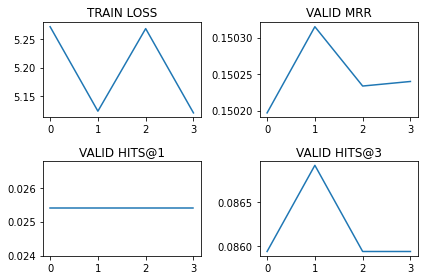

In [191]:
evaluator = Evaluator()
kge_model = KGEModel(
        nentity=nentity,
        nrelation=nrelation,
        embedding_size=EMBEDDING_SIZE,
        gamma=GAMMA,
        double_entity_embedding=double_entity_embedding,
        double_relation_embedding=double_relation_embedding,
        evaluator=evaluator
    )
kge_model = kge_model.cuda()
optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, kge_model.parameters()), 
            lr=LEARNING_RATE
        )

log, mrr, hits1, hits3, hits10 = [], [], [], [], []

for num_epoch in (range(EPOCH)):
    train_loader=DataLoader(KGEDataset(train),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)

    for iteration,train_values in tqdm(enumerate(train_loader)):
        
        kge_model.train()
        optimizer.zero_grad()

        head,tail,relation,neg_head,neg_tail,subsampling_weight = train_values

        head = head.cuda()
        tail = tail.cuda()
        relation = relation.cuda()
        neg_head = neg_head.cuda()
        neg_tail = neg_tail.cuda()
        subsampling_weight = subsampling_weight.cuda()

        positive_score, negative_tail_score, negative_head_score = kge_model(head, tail, relation, neg_head, neg_tail)

        positive_score = F.logsigmoid(positive_score).squeeze(dim = 1)
        if ADVERSARIAL_TEMPERATURE!=0.0:
            #In self-adversarial sampling, we do not apply back-propagation on the sampling weight
            negative_tail_score = (F.softmax(negative_tail_score * ADVERSARIAL_TEMPERATURE, dim = 1).detach() 
                              * F.logsigmoid(-negative_tail_score)).sum(dim = 1)
            negative_head_score = (F.softmax(negative_head_score * ADVERSARIAL_TEMPERATURE, dim = 1).detach() 
                              * F.logsigmoid(-negative_head_score)).sum(dim = 1)
        else:
            negative_tail_score = F.logsigmoid(-negative_tail_score).mean(dim = 1)
            negative_head_score = F.logsigmoid(-negative_head_score).mean(dim = 1)

        if uni_weight:
            positive_sample_loss = - positive_score.mean()
            negative_sample_tail_loss = - negative_tail_score.mean()
            negative_sample_head_loss = - negative_head_score.mean()
        else:
            positive_sample_loss = - (subsampling_weight * positive_score).sum()/subsampling_weight.sum()
            negative_sample_tail_loss = - (subsampling_weight * negative_tail_score).sum()/subsampling_weight.sum()
            negative_sample_head_loss = - (subsampling_weight * negative_head_score).sum()/subsampling_weight.sum()

        loss = (2*positive_sample_loss + negative_sample_tail_loss+negative_sample_head_loss)/4

        if REGULARIZATION != 0.0:
            #Use L3 regularization for ComplEx and DistMult
            REGULARIZATION = REGULARIZATION * (
                kge_model.entity_embedding.norm(p = 3)**3 + 
                kge_model.relation_embedding.norm(p = 3).norm(p = 3)**3
            )
            loss = loss + REGULARIZATION
        
        loss.backward()

        log.append(loss)

        optimizer.step()
    
# VALID
        if (iteration+1)%VALIDATION_INTERVAL == 0:
            valid_loader=DataLoader(KGEDataset(valid,mode='test'),batch_size=BATCH_SIZE_TEST,shuffle=False,num_workers=NUM_WORKERS)
            mrr_temp, hits1_temp, hits3_temp, hits10_temp = [],[],[],[]

            for valid_values in valid_loader:
                kge_model.eval()

                head,tail,relation,neg_head,neg_tail = valid_values

                head = head.cuda()
                tail = tail.cuda()
                relation = relation.cuda()
                neg_head = neg_head.cuda()
                neg_tail = neg_tail.cuda()

                with torch.no_grad():
                    positive_score, negative_tail_score, negative_head_score = kge_model(head, tail, relation, neg_head, neg_tail)

                    mrr_mean, hits1_mean, hits3_mean, hits10_mean = [metric.mean() for metric in kge_model.evaluator.eval({'y_pred_pos': positive_score, 'y_pred_neg': torch.cat((negative_tail_score,negative_head_score), dim=1)})]

                    mrr_temp.append(mrr_mean)
                    hits1_temp.append(hits1_mean)
                    hits3_temp.append(hits3_mean)
                    hits10_temp.append(hits10_mean)
            
            mrr.append(torch.tensor(mrr_temp).mean())
            hits1.append(torch.tensor(hits1_temp).mean())
            hits3.append(torch.tensor(hits3_temp).mean())
            hits10.append(torch.tensor(hits10_temp).mean())

        if (iteration+1)%SAVE_ITERATION == 0:
            torch.save(list(torch.tensor(log)), NAME_PATH+'//loss.pt')
            torch.save(mrr, NAME_PATH+'//mrr.pt')

            plt.clf()
            figure, axis = plt.subplots(2, 2)
            axis[0,0].plot(torch.tensor(log))
            axis[0,0].set_title("TRAIN LOSS")
  
            axis[0,1].plot(mrr)
            axis[0,1].set_title("VALID MRR")

            axis[1,0].plot(hits1)
            axis[1,0].set_title("VALID HITS@1")

            axis[1,1].plot(hits3)
            axis[1,1].set_title("VALID HITS@3")

            figure.tight_layout()
        
            plt.savefig(NAME_PATH+'//result.png', dpi=300, facecolor='w', edgecolor='w')

#### TEST

In [195]:
mrr_test, hits1_test, hits3_test, hits10_test = [], [], [], []

test_loader=DataLoader(KGEDataset(test,mode='test'),batch_size=BATCH_SIZE_TEST,shuffle=False,num_workers=NUM_WORKERS)
for test_values in test_loader:
        kge_model.eval()
        
        head,tail,relation,neg_head,neg_tail = test_values

        head = head.cuda()
        tail = tail.cuda()
        relation = relation.cuda()
        neg_head = neg_head.cuda()
        neg_tail = neg_tail.cuda()

        with torch.no_grad():
                    positive_score, negative_tail_score, negative_head_score = kge_model(head, tail, relation, neg_head, neg_tail)

                    mrr_mean, hits1_mean, hits3_mean, hits10_mean = [metric.mean() for metric in kge_model.evaluator.eval({'y_pred_pos': positive_score, 'y_pred_neg': torch.cat((negative_tail_score,negative_head_score), dim=1)})]

                    mrr_test.append(mrr_mean)
                    hits1_test.append(hits1_mean)
                    hits3_test.append(hits3_mean)
                    hits10_test.append(hits10_mean)

dict_metrics = {'MRR': float(torch.tensor(mrr_test).mean()),
                'HITS@1': float(torch.tensor(hits1_test).mean()),
                'HITS@3': float(torch.tensor(hits3_test).mean()),
                'HITS@10': float(torch.tensor(hits10_test).mean())}

with open(NAME_PATH+'//metrics.txt', 'w') as var_file:
            json.dump(dict_metrics, var_file)

print(dict_metrics)

{'MRR': 0.15877214074134827, 'HITS@1': 0.021484375, 'HITS@3': 0.099609375, 'HITS@10': 0.6318359375}


In [ ]:
# # Чтение
# with open('file.txt', 'r') as file:
#     log = json.load(file)

# torch.load('file.pt')